In [40]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from math import ceil
from pipeline_func import create_and_fit_decision_tree, calculate_prediction, calculate_accuracy, create_submission, store_accuracy_results

# temporary files: /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# read data and check for null

dt = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print("Nulls found in: ")
print('-- train data')
dt.head()
dt.describe()
print(dt.loc[:,dt.isnull().any()].columns)

print('-- test data')
print(test.loc[:,test.isnull().any()].columns)

Nulls found in: 
-- train data
Index(['Age', 'Cabin', 'Embarked'], dtype='object')
-- test data
Index(['Age', 'Fare', 'Cabin'], dtype='object')


# Data preprocessing

### Encoding into numerical values
This is done on both training and test set ('translation')

In [3]:
# code category into binary var
gender = {'male': 0, 'female': 1}
dt['Sex_bin'] = pd.DataFrame([gender[g] for g in dt.Sex])
test['Sex_bin'] = pd.DataFrame([gender[g] for g in test.Sex])

### Data matching
This is done on both training and test set ('translation')

In [4]:
# titles table
title_dict = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
             "Don": "Royalty", "Dona": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
             "the Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty"}

# titles extraction and matching
titles_extrd_train = [s[1].strip() for s in dt.Name.str.split('[,|.]')]
dt['Title'] = titles_extrd_train
dt['Title_unif'] = [title_dict[title] for title in titles_extrd_train]
print("There are " + str(sum(dt.Title_unif.isnull())) + " empty titles in the dt data set")

titles_extrd_test = [s[1].strip() for s in test.Name.str.split('[,|.]')]
test['Title'] = titles_extrd_test
test['Title_unif'] = [title_dict[title] for title in titles_extrd_test]
print("There are " + str(sum(test.Title_unif.isnull())) + " empty titles in the test data set")

There are 0 empty titles in the dt data set
There are 0 empty titles in the test data set


### Split into train/validation/test

In [5]:
# split dt into train and validation sets
train = dt.sample(frac=0.8, random_state=0)
validation = dt.drop(train.index)

len(train) + len(validation) == len(dt)

True

### Handling outliers
This is evaluated only on training data set ('transformation'), then calculated thresholds are applied in validation/test sets

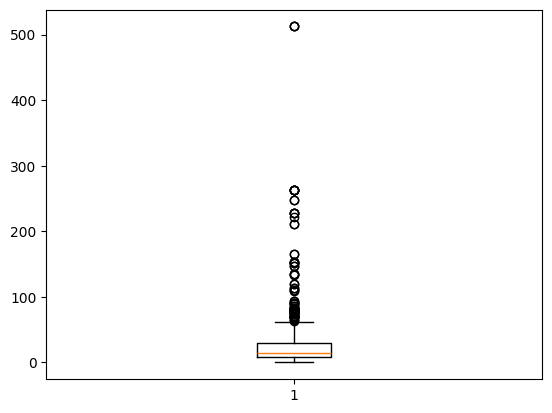

512.3292
Lower whisker:  0.0
Upper whisker:  61.9792


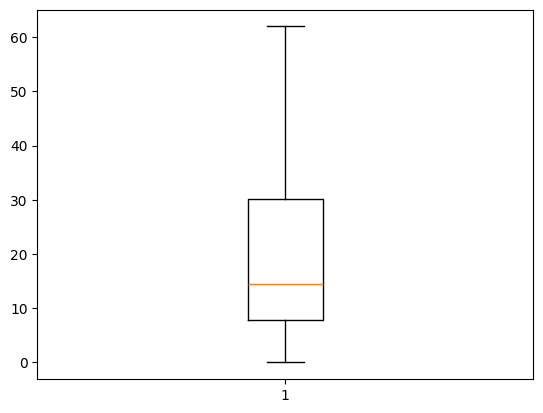

In [6]:
### training set
# find lower and upper whisker of a boxplot (representing min and max of middle 50% interval)
plt.boxplot(train.Fare)
plt.show()

# q1 = train.Fare.quantile(0.25)
# q3 = train.Fare.quantile(0.75)
# low_whisker = train.Fare[train.Fare >= q1 - 1.5*(q3-q1)].min()
# upp_whisker = train.Fare[train.Fare <= q3 + 1.5*(q3-q1)].max()

def remove_outliers(train, validation, test, feature):
    feature_boxplot = plt.boxplot(train[feature])
    plt.close()

    [low_whisker, upp_whisker] = [item.get_ydata()[1] for item in feature_boxplot['whiskers']]
    print("Lower whisker: ", low_whisker)
    print("Upper whisker: ", upp_whisker)

    # create new column with replaced values
    train[feature+'_wt_outliers'] = train[feature]
    train.loc[train[feature+'_wt_outliers'] < low_whisker, feature+'_wt_outliers'] = low_whisker
    train.loc[train[feature+'_wt_outliers'] > upp_whisker, feature+'_wt_outliers'] = upp_whisker

    # using the same thresholds as it would be on the real production data
    validation[feature+'_wt_outliers'] = validation[feature]
    validation.loc[validation[feature+'_wt_outliers'] < low_whisker, feature+'_wt_outliers'] = low_whisker
    validation.loc[validation[feature+'_wt_outliers'] > upp_whisker, feature+'_wt_outliers'] = upp_whisker

    test[feature+'_wt_outliers'] = test[feature]
    test.loc[test[feature+'_wt_outliers'] < low_whisker, feature+'_wt_outliers'] = low_whisker
    test.loc[test[feature+'_wt_outliers'] > upp_whisker, feature+'_wt_outliers'] = upp_whisker

    return train, validation, test

print(dt.Fare.max())
train, validation, test = remove_outliers(train, validation, test, 'Fare')
plt.boxplot(train.Fare_wt_outliers)
plt.show()


### Inputing missing values
This is evaluated only on training data set ('transformation'), then calculated thresholds are applied in validation/test sets

In [7]:
# display missing age data
dt[dt.Age.isnull()]

# we need to make missing age data imputation
# approach 1: IterativeImputer from sklearn

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

print('Avg age mean: ', train.Age.mean())

imp_mean = IterativeImputer(random_state=0, min_value=0, max_value=train.Age.max())

# # encode Embarked categorical array into numerical -> tbf
# enc = OneHotEncoder()
# enc.fit_transform(train.Embarked.to_numpy().reshape(-1,1)).toarray()
# # ...
# X = ['Pclass', 'Sex_bin', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']

# what if we take only correlated data?

X = ['Pclass', 'Sex_bin', 'Age', 'SibSp', 'Parch', 'Fare']
train_transf = pd.DataFrame(imp_mean.fit_transform(train[X].to_numpy()), columns=X)
train['Age_suppl_i'] = train_transf.Age

# use the same imputer to supply missing values on the validation/test set
validation_transf = pd.DataFrame(imp_mean.transform(validation[X].to_numpy()), columns=X)
validation_transf['Age_suppl_i'] = validation_transf.Age

test_transf = pd.DataFrame(imp_mean.transform(test[X].to_numpy()), columns=X)
test_transf['Age_suppl_i'] = test_transf.Age

# approach 2: mean value aggregated on categories

# calculate mean age value by title
mean_age_by_title = train.groupby(by='Title_unif').mean(numeric_only=True).Age.to_dict()
# replace null values
print(mean_age_by_title)
train['Age_suppl_ii'] = train.Age.fillna(train.Title_unif.map(mean_age_by_title))
validation['Age_suppl_ii'] = validation.Age.fillna(validation.Title_unif.map(mean_age_by_title))
test['Age_suppl_ii'] = test.Age.fillna(test.Title_unif.map(mean_age_by_title))
# train.Age_suppl_ii.isnull().any()

# dt_wt_age_nan = dt[~dt.Age.isnull()]
#plot_boxplot_grouped_by_another_col(dt_wt_age_nan, 'Age', 'Title_unif')

Avg age mean:  29.505356521739134
{'Master': 4.602666666666667, 'Miss': 21.297619047619047, 'Mr': 32.246875, 'Mrs': 36.8125, 'Officer': 56.6, 'Royalty': 42.642857142857146}


### Training

In [8]:
# store accuracy results for each model
accuracy_results = pd.DataFrame(columns=['model', 'features', 'train_acc', 'validation_acc', 'test_acc'])

In [9]:
# pipeline
def run_dt(train, validation, X, Y, criterion, show_plot=True):
    # create and train the tree
    model = create_and_fit_decision_tree(train, X, Y, criterion, show_plot)

    # create prediction on train and validation sets
    train_predict = calculate_prediction(model, train, X)
    validation_predict = calculate_prediction(model, validation, X)

    # print accuracy of the prediction
    train_acc = calculate_accuracy("Train", train[Y], train_predict)
    validation_acc = calculate_accuracy("Validation", validation[Y], validation_predict)
    
    return model, train_acc, validation_acc

In [10]:
def run_rf(train, validation, X, Y, n_of_trees, max_leaf_nodes):
    # create and train the random forest
    model = RandomForestClassifier(n_estimators=n_of_trees, max_leaf_nodes=max_leaf_nodes)
    model.fit(train[X],train[Y])

    # create prediction on train and validation sets
    train_predict = calculate_prediction(model, train, X)
    validation_predict = calculate_prediction(model, validation, X)

    # print accuracy of the prediction
    train_acc = calculate_accuracy("Train", train[Y], train_predict)
    validation_acc = calculate_accuracy("Validation", validation[Y], validation_predict)
    
    return model, train_acc, validation_acc

The plot below presents the correlation between features. It helps to identify the potential features helpful for training the model as well as observing where the same information might be brought by different features (e.g. Fare is correlated with Pclass)

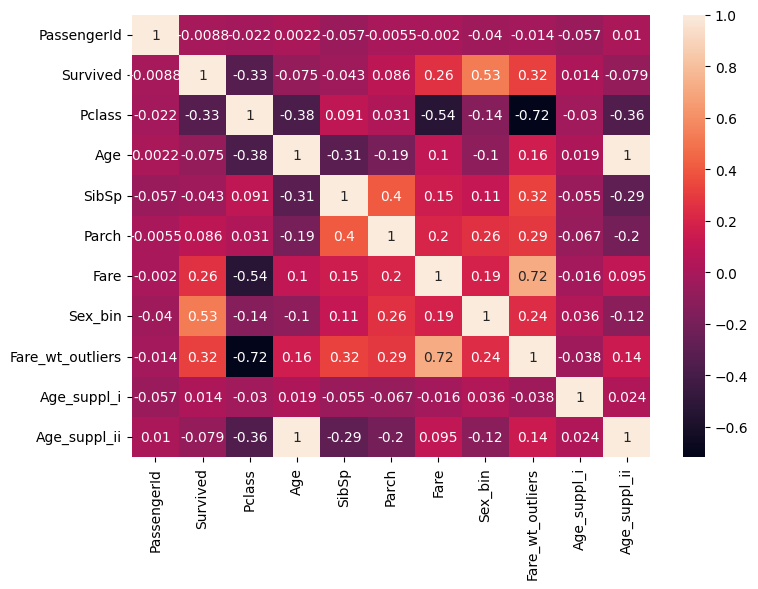

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(numeric_only=True), annot=True)
plt.tight_layout()

# Decision Tree 1

Features: Sex_bin

Criterion: Gini impurity

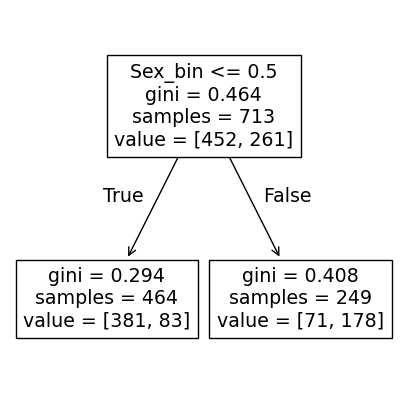

Train :  559.0  correctly classified samples -  78.4 %
Validation :  142.0  correctly classified samples -  79.78 %


In [12]:
X1 = ['Sex_bin']
Y = 'Survived'
criterion = "gini"

dtree1, train_acc1, validation_acc1 = run_dt(train, validation, X1, Y, criterion)
# value array tells how many samples fall into each to-be-predicted category (value = [549, 342] means that
# there are 549 0s and 342 1s)
# gini index drops with the division of the node -> good
subm1 = create_submission(dtree1, test, X1)
subm1.to_csv('./../output/submission1.csv', index=False)
# test submission on Kaggle resulted in 0.76555

# store accuracy
accuracy_results = store_accuracy_results(accuracy_results, 'dtree1', X1, train_acc1, validation_acc1, test_acc=0.76555)

## Gini index

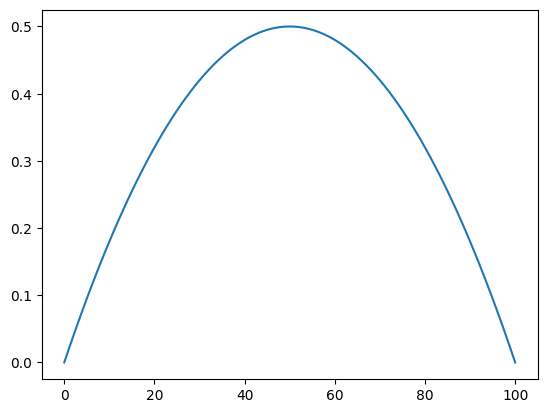

In [13]:
###  Gini index - visualization on dummy data
n = 100
# create 101 classes of different proportions of 0s and 1s
classes = pd.DataFrame(data=np.zeros(shape=(n,n+1)),columns = ['c'+str(k) for k in range(n+1)])
for k in range(1,n+1):
    classes['c'+str(k)].iloc[0:k] = 1
# print(classes)
cnt = classes.sum()

# calculate prob of 0 and 1 for each node
probs_0 = [(n-c)/n for c in cnt]
probs_1 = [c/n for c in cnt]

# Gini formula for node (class) with given no of 0s and 1s = 1-(P(0)^2+P(1)^2), 
# where P - probability function (based on frequency)
# In general, Gini formula for class c: G(c)= 1-sum{k in 1..n} P(k)^2, where n is number of different elements in class c

gini_index = [1 - (probs_0[k]**2 + probs_1[k]**2) for k in range(n+1)]
plt.plot(gini_index)

# The closer Gini index is to 0, the more purity we have in the node of the tree

# Decision Tree 2

Features: Sex_bin

Criterion: entropy

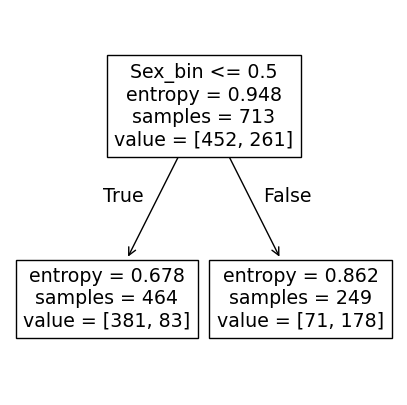

Train :  559.0  correctly classified samples -  78.4 %
Validation :  142.0  correctly classified samples -  79.78 %
True


In [14]:
X2 = ['Sex_bin']
Y = 'Survived'
criterion = "entropy"

dtree2, train_acc2, validation_acc2 = run_dt(train, validation, X2, Y, criterion)
subm2 = create_submission(dtree2, test, X2)
subm2.to_csv('./../output/submission2.csv', index=False)
print(all(subm2 == subm1))
# identical submission to subm1

accuracy_results = store_accuracy_results(accuracy_results, 'dtree2', X2, train_acc2, validation_acc2, test_acc=0.76555)

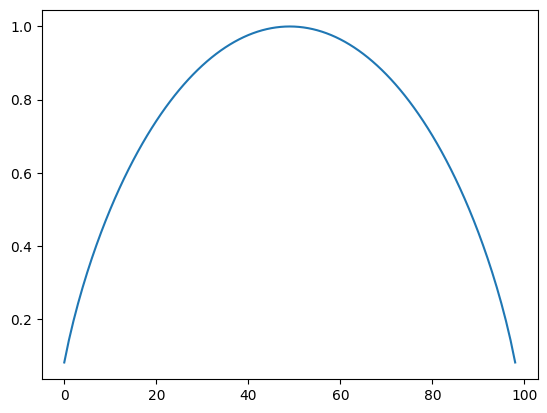

In [15]:
### entropy - visualization on dummy data
from math import log2

entropy = [-(probs_0[k]*log2(probs_0[k]) + probs_1[k]*log2(probs_1[k])) for k in range(1,n)] # for k=0 and k=n+1 log doesnt exist
plt.plot(entropy)

# Decision Tree 3

Features: Sex_bin, Pclass

Criterion: gini

In [16]:
# contingency table (crosstab)
sex_vs_pclass = pd.pivot_table(train, values='PassengerId', index='Sex', columns='Pclass', aggfunc='count')
sex_vs_pclass

Pclass,1,2,3
Sex,,,
female,74,59,116
male,96,83,285


In [17]:
import scipy.stats as stats

# chi-squared test statistic, sample size, and minimum of rows and columns
chi2, pval, _, _ = stats.chi2_contingency(sex_vs_pclass, correction=False)
# H0: there is no dependence between sex and pclass
# p = probability that the dependence is caused by random noise; if p<0.05, we can deny H0
print("p-value: ", pval)

# chi2 is affected by sample size and no of rows and columns 
# Cramer's V attempts to adjust for these
n = np.sum(sex_vs_pclass).sum() 
minDim = min(sex_vs_pclass.shape)-1 # no of degrees of freedom

# calculate Cramer's V - effect size measurement that tells how strong the relationship is
V = np.sqrt((chi2/n) / minDim)
print("Cramer's V: ", V)
# 0 - no correlation, 1 - strong correlation

# interpretation of Cramer's V depends on no of degrees of freedom
# there are many rules of thumb but in general for df=1 V=0.14 is pretty small

p-value:  0.0006667944244384896
Cramer's V:  0.1432250141596954


c:\Users\katar\python_envs\kaggle-titanic\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


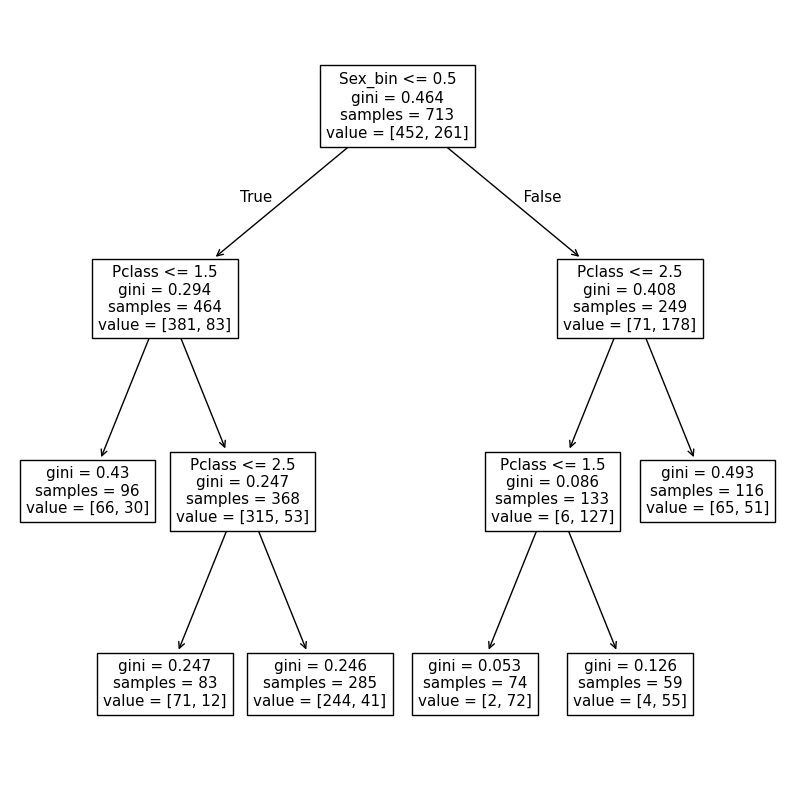

Train :  573.0  correctly classified samples -  80.36 %
Validation :  128.0  correctly classified samples -  71.91 %


In [18]:
X3 = ['Sex_bin', 'Pclass']
Y = 'Survived'
criterion = "gini"

dtree3, train_acc3, validation_acc3 = run_dt(train, validation, X3, Y, criterion)
subm3 = create_submission(dtree3, test, X3)
subm3.to_csv('./../output/submission3.csv', index=False)
# train fits better, validation worse - suggest overfitting
# test submission 0.77511 (only slightly better

accuracy_results = store_accuracy_results(accuracy_results, 'dtree3', X3, train_acc3, validation_acc3, test_acc=0.77511)

# Decision Tree 4

Features: Sex_bin, Pclass, Fare_wt_outliers

Criterion: gini

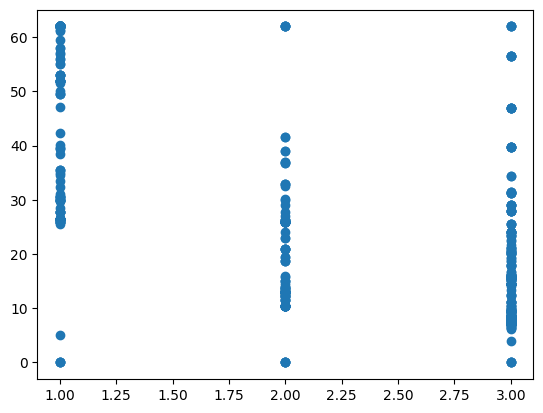

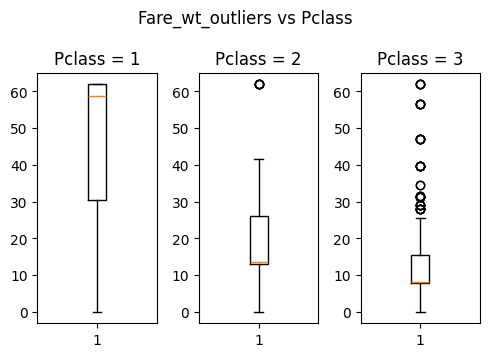

In [19]:
# plot Pclass vs Fare amount to see if there is any correspondence
plt.scatter(train.Pclass, train.Fare_wt_outliers)
plt.show()

# use boxplot to have more insight
# train[['Pclass','Fare']].boxplot(column='Fare',by='Pclass')

def plot_boxplot_grouped_by_another_col(data, col_to_plot, col_to_group_by):
    col_uniques = np.sort(data[col_to_group_by].unique())

    ncols = len(col_uniques) if len(col_uniques)<=5 else 5
    nrows = ceil(len(col_uniques)/5)

    fig, axes = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*1.2))
    fig.suptitle(col_to_plot + ' vs ' + col_to_group_by)

    for (ax, c) in zip(axes.reshape(-1,), col_uniques):
        ax.boxplot(x=data[col_to_plot][data[col_to_group_by]==c])
        ax.set_title(col_to_group_by + ' = ' + str(c))

    fig.tight_layout()
    plt.show()

plot_boxplot_grouped_by_another_col(train, 'Fare_wt_outliers', 'Pclass')
# Fare clearly depends on the Pclass, there are only few outliers

In [20]:
accuracy_results

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511


In [21]:
# test if adding correlated information causes overfitting
X4 = ['Sex_bin', 'Pclass', 'Fare_wt_outliers']
Y = 'Survived'
criterion = "gini"

dtree4, train_acc4, validation_acc4 = run_dt(train, validation, X4, Y, criterion, show_plot=False)
subm4 = create_submission(dtree4, test, X4)
subm4.to_csv('./../output/submission4.csv', index=False)

# train and validation results a lot better (unexpected for validation), test result - worse (quite expected)
accuracy_results = store_accuracy_results(accuracy_results, 'dtree4', X4, train_acc4, validation_acc4, test_acc=0.77033)

Train :  638.0  correctly classified samples -  89.48 %
Validation :  142.0  correctly classified samples -  79.78 %


# Decision Tree 5

Features: Sex_bin, Fare

Criterion: gini

In [22]:
X5 = ['Sex_bin', 'Fare']
Y = 'Survived'
criterion = "gini"

dtree5, train_acc5, validation_acc5 = run_dt(train, validation, X5, Y, criterion, show_plot=False)
subm5 = create_submission(dtree5, test, X5)
subm5.to_csv('./../output/submission5.csv', index=False)


# train and validation results similar to dtree4, test result again worse
accuracy_results = store_accuracy_results(accuracy_results, 'dtree5', X5, train_acc5, validation_acc5, test_acc=0.76076)


Train :  647.0  correctly classified samples -  90.74 %
Validation :  142.0  correctly classified samples -  79.78 %


In [23]:
accuracy_results

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511
3,dtree4,"[Sex_bin, Pclass, Fare_wt_outliers]",0.894811,0.797753,0.77033
4,dtree5,"[Sex_bin, Fare]",0.907433,0.797753,0.76076


# Decision Tree 6

Features: Sex_bin, Pclass, Fare

Criterion: gini

In [24]:
X6 = ['Sex_bin', 'Pclass', 'Fare']
Y = 'Survived'
criterion = "gini"

dtree6, train_acc6, validation_acc6 = run_dt(train, validation, X6, Y, criterion, show_plot=False)
subm6 = create_submission(dtree6, test, X6)
subm6.to_csv('./../output/submission6.csv', index=False)

accuracy_results = store_accuracy_results(accuracy_results, 'dtree6', X6, train_acc6, validation_acc6, test_acc=0.76555)

Train :  648.0  correctly classified samples -  90.88 %
Validation :  143.0  correctly classified samples -  80.34 %


# Decision Tree 7

Features: Sex_bin, Pclass, Age

Criterion: gini

In [25]:
X7 = ['Sex_bin', 'Pclass', 'Age']
Y = 'Survived'
criterion = "gini"

dtree7, train_acc7, validation_acc7 = run_dt(train, validation, X7, Y, criterion, show_plot=False)
subm6 = create_submission(dtree7, test, X7)
subm6.to_csv('./../output/submission7.csv', index=False)

accuracy_results = store_accuracy_results(accuracy_results, 'dtree7', X7, train_acc7, validation_acc7, test_acc=0.74401)

Train :  632.0  correctly classified samples -  88.64 %
Validation :  139.0  correctly classified samples -  78.09 %


# Cross-validation

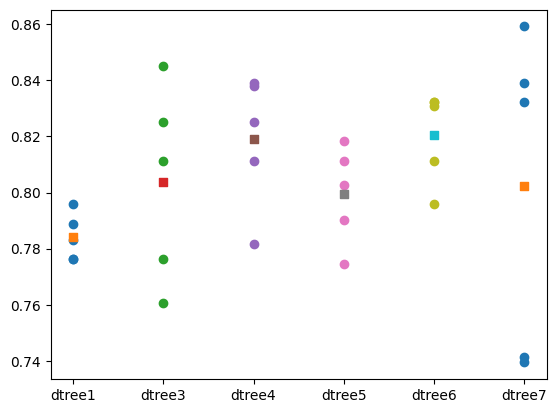

Average cv_score:
dtree1    0.784034
dtree3    0.803644
dtree4    0.819049
dtree5    0.799409
dtree6    0.820457
dtree7    0.802236
dtype: float64


In [26]:
from sklearn.model_selection import cross_val_score
cv_score = {}
cv_no = 5
cv_score['dtree1'] = cross_val_score(dtree1, train[X1], train[Y], cv=cv_no)
cv_score['dtree3'] = cross_val_score(dtree3, train[X3], train[Y], cv=cv_no)
cv_score['dtree4'] = cross_val_score(dtree4, train[X4], train[Y], cv=cv_no)
cv_score['dtree5'] = cross_val_score(dtree5, train[X5], train[Y], cv=cv_no)
cv_score['dtree6'] = cross_val_score(dtree6, train[X6], train[Y], cv=cv_no)
cv_score['dtree7'] = cross_val_score(dtree7, train[X7], train[Y], cv=cv_no)

# plt.scatter(pd.DataFrame(cv_score))
cv_score = pd.DataFrame(cv_score)
for cv in cv_score.columns:
    plt.scatter([cv]*cv_no, cv_score[cv])
    plt.scatter(cv, cv_score[cv].mean(), marker='s')
plt.show()

print('Average cv_score:')
print(cv_score.mean())

In [27]:
accuracy_results

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511
3,dtree4,"[Sex_bin, Pclass, Fare_wt_outliers]",0.894811,0.797753,0.77033
4,dtree5,"[Sex_bin, Fare]",0.907433,0.797753,0.76076
5,dtree6,"[Sex_bin, Pclass, Fare]",0.908836,0.803371,0.76555
6,dtree7,"[Sex_bin, Pclass, Age]",0.886396,0.780899,0.74401


 # Ensemble methods

 Aggregating various predictors into one often results in the better classifier. This can be done in few ways:
 - hard voting classifier - aggregates the predictions of each classifier and predict the class that get the most votes (law of large numbers)
 - bagging/pasting - using the same training algorithm for every predictor and training them on different random subsets of the training set with/without replacement; aggregates typically hard-vote/soft-vote (based on class probability) for classification or average for regression

 Bagging has slightly higher bias but because of more diversity, predictors end up being less correlated hence variance is reduced, which generally leads to better results.

 Ensemble methods work best when the predictors are sufficiently diverse (independent from each other). They typically have comparable bias but smaller variance (they make roughly the same number of errors on the training set but they generalize better on test set - decision boundary is less irregular, less overfitting)

Source: "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" A. Geron


# Random Forest

RF is an ensemble of multiple DT, typically aggregated using bagging method.

Features: Sex_bin, Pclass, Fare

In [ ]:
X11 = ['Sex_bin', 'Pclass', 'Fare']
Y = 'Survived'

rf11, train_acc11, validation_acc11 = run_rf(train, validation, X11, Y, n_of_trees=500, max_leaf_nodes=30)
subm11 = create_submission(rf11, test, X11)
subm11.to_csv('./../output/submission11.csv', index=False)

accuracy_results = store_accuracy_results(accuracy_results, 'rf11', X11, train_acc11, validation_acc11, test_acc=0.75598)

# feature's importance measured by how much they reduce impurity - can be useful for data insight
for feature_name, feature_score in zip(X11, rf11.feature_importances_):
    print(feature_name, feature_score)

Train :  609.0  correctly classified samples -  85.41 %
Validation :  136.0  correctly classified samples -  76.4 %
Sex_bin 0.42493968859046405
Pclass 0.1801834129321304
Fare 0.3948768984774055


In [29]:
# encode Title_unif categorical array into numerical
enc_title = OneHotEncoder()
enc_title_fit = enc_title.fit_transform(train.Title_unif.to_numpy().reshape(-1,1)).toarray()
train = pd.concat([train, pd.DataFrame(enc_title_fit, columns=enc_title.get_feature_names_out(['Title_dict']), index=train.index)], axis=1)

# use the encoder on the validation and test data sets
enc_validation_fit = enc_title.transform(validation.Title_unif.to_numpy().reshape(-1,1)).toarray()
validation = pd.concat([validation, pd.DataFrame(enc_validation_fit, columns=enc_title.get_feature_names_out(['Title_dict']), index=validation.index)], axis=1)

enc_test_fit = enc_title.transform(test.Title_unif.to_numpy().reshape(-1,1)).toarray()
test = pd.concat([test, pd.DataFrame(enc_test_fit, columns=enc_title.get_feature_names_out(['Title_dict']), index=test.index)], axis=1)

print(enc_title.get_feature_names_out(['Title_dict']))

['Title_dict_Master' 'Title_dict_Miss' 'Title_dict_Mr' 'Title_dict_Mrs'
 'Title_dict_Officer' 'Title_dict_Royalty']


Train :  635.0  correctly classified samples -  89.06 %
Validation :  145.0  correctly classified samples -  81.46 %


<BarContainer object of 12 artists>

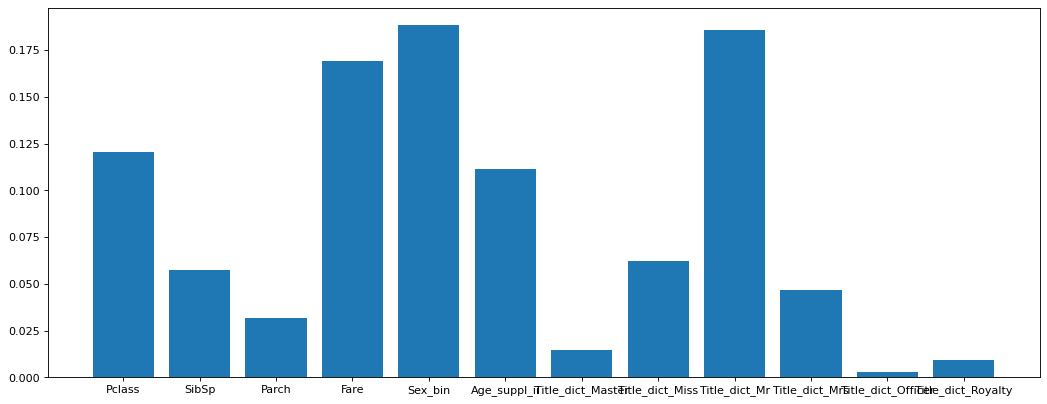

In [47]:
X12 = ['Pclass', 'SibSp','Parch', 'Fare', 'Sex_bin', 'Age_suppl_ii'] + enc_title.get_feature_names_out(['Title_dict']).tolist()
Y = 'Survived'

rf12, train_acc11, validation_acc12 = run_rf(train, validation, X12, Y, n_of_trees=500, max_leaf_nodes=30)
subm12 = create_submission(rf12, test, X12)
subm12.to_csv('./../output/submission12.csv', index=False)

accuracy_results = store_accuracy_results(accuracy_results, 'rf11', X11, train_acc11, validation_acc11, test_acc=0.78229)

# feature's importance measured by how much they reduce impurity - can be useful for data insight
figure(figsize=(16, 6), dpi=80)
plt.bar(X12, rf12.feature_importances_, )
# for feature_name, feature_score in zip(X12, rf12.feature_importances_):
#     print(feature_name, feature_score)